In [9]:
%load_ext autoreload
%autoreload

import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import warnings as w
from IPython.display import Image

from utils import qualityMACAPE, qualityRMSE, InitExponentialSmoothing, AdaptiveExponentialSmoothing # TheilWageExponentialSmoothing

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1 align="center"> Practice: realize compositions</h1>
# Adaptive selection
** Question:**
* What is adaptive selection?
* Which external parameters does it have?
* Describe case when adaptive selection works bad.

In [2]:
def MAE(x, predicted):
    return np.abs(x - predicted)

def MSE(x, predicted):
    return (x - predicted) ** 2

def exp_MAE(x, predicted):
    return np.exp(np.abs(x - predicted))

def exp_MSE(x, predicted):
    return np.exp((x - predicted) ** 2)

In [3]:
def adaptive_selection(x, h, params, loss = MAE):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        eps <scalar> - bound for best indistinctive models
        base_algs - array of <dict> with params
            base_alg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # base algs Forecasts     
    base_algs = params['base_alg_params']
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(N):
        FORECAST_BA[ba]= eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_algs_params'])")
        
    # internal params of composition
    gamma = params['gamma']
    eps = params['eps']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1= np.zeros(N)  # initialization of errors of base algorithms 
    j_best = 0
    
    y=1.5
        
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                'TODO: check this code'
                e1 = gamma * loss(x[t], FORECAST_BA.transpose()[t])+(1-gamma)*e1
                if np.isnan(e1.sum()):
                    e1=np.zeros(N)
                # select best algorithm at the moment t
                j_best = np.argmin(e1)#'TODO: find index of best base alg'
                # select best indistinctive
                idx_bestinsdistinctive =[]
                for i in range(N):
                    if abs(e1[i]-e1[j_best])<eps:
                        idx_bestinsdistinctive.append(i)# 'TODO: find indexes of best indistinctive algorithms'
                
                y = FORECAST_BA.transpose()[t + h,idx_bestinsdistinctive].mean()
                # else do nothing
#         else do nothing
            
            
        FORECAST[t+h] = y
    return FORECAST

In [4]:
def holt_add(alpha, cur, last, holt_add_last):
    if np.isnan(holt_add_last.sum()):
        holt_add_last = cur - last
    res = (cur - last) * alpha + (1 - alpha) * holt_add_last
    return res

In [5]:
def adaptive_composition(x, h, params, loss = exp_MAE):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        base_algs - array of <dict> with params
            base_alg <string> - name of base algorithm
            base_alg_params <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # base algs Forecasts     
    base_algs = params['base_alg_params']
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(base_algs)):
        FORECAST_BA[ba]= eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_algs_params'])")
    
    # internal params of composition
    gamma = params['gamma']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1= np.array(np.ones(N))  # initialization of errors of base algorithms 
    weights = np.array(np.zeros(N))
    
    y=1.5
    e_predicted = "nan"
    gamma1 = 0.1
    trend = x[0]
    
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                if (e_predicted == "nan"):
                    e_predicted = loss(x[t], FORECAST_BA.transpose()[t])
                e_predicted = gamma1 * loss(x[t], FORECAST_BA.transpose()[t]) + \
                    (1 - gamma1) * e_predicted # add holt!!! alpha = 0.1, beta = 0.3
                level = e_predicted
                trend = holt_add(0.3, x[t], x[t - 1], trend)
                e1_Holt = level + trend
                #print("current error:  ", np.abs(x[t]-FORECAST_BA.transpose()[t]))
                #print(e1_Holt)
                if np.isnan(e1_Holt.sum()):
                    e1_Holt=np.ones(N)
                inv_e = np.array([x**(-1) for x in e1_Holt])
                
                weights = inv_e/inv_e.sum()
                
#               Calculate forecast of the composition
                y = FORECAST_BA.transpose()[t + h].dot(weights)
            
        FORECAST[t+h] = y
    return FORECAST

# Define base algorithms

In [3]:
base_algs = [{'base_alg':'InitExponentialSmoothing', 'base_algs_params':{'alpha':0.9, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 'base_algs_params':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 'base_algs_params':{'alpha':0.2,'gamma':1, 'AdaptationPeriod':10}},
#            {'base_alg':'AdaptiveSimpleExponentialSmoothing', 'base_algs_params':{'alpha':0.1, 'gamma':0.01}},
            {'base_alg':'TheilWageExponentialSmoothing', 'base_algs_params':{'alpha':0.3, 'beta':0.9,'delta':0.9, 'gamma':0.1, 'seasonality_period':1}}
]

In [4]:
for ba in range(len(base_algs)):
    print(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")

InitExponentialSmoothing(x,h,base_algs[0]['base_alg_params'])
AdaptiveExponentialSmoothing(x,h,base_algs[1]['base_alg_params'])
AdaptiveExponentialSmoothing(x,h,base_algs[2]['base_alg_params'])
TheilWageExponentialSmoothing(x,h,base_algs[3]['base_alg_params'])


In [5]:
# Read datae (time series)
ts = pd.read_csv('https://raw.githubusercontent.com/ml-mipt/ml-mipt-part2/master/2017/seminars/1_ts_esm/data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
# ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.')
ts = ts.sort_index() # sort index

In [6]:
# Define forecast perameters
h =1 # horizon forecast

# structure of forecasts
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h)))
                      , columns = ts.columns)
FRC_TS = dict()

In [10]:
# run (build forecast) simple exponential smoothing
for cntr in ts.columns:
    frc_ts[cntr]= AdaptiveExponentialSmoothing(ts[cntr],h, {'alpha':0.1,'gamma':0.01,  'AdaptationPeriod':10})

In [11]:
# run Adaptive Selection
#gammas = [0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999]
gamma=0.0001
eps = 1.0
for cntr in ts.columns:
    frc_ts[cntr]= adaptive_selection(ts[cntr],h, {'gamma':gamma, 'eps': eps, 'base_alg_params':base_algs})
FRC_TS['AS gamma %.4f eps %.4f' % (gamma, eps)] = frc_ts

NameError: name 'adaptive_selection' is not defined

In [ ]:
# draw forecast of Adaprive Selection
alg_name = 'AS gamma 0.0001 eps 1.0000'
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    forecast = FRC_TS[alg_name]
    forecast[col].plot(color='red', label=alg_name, alpha = 1)
    plt.title(col)
    plt.legend()
    plt.show()

# Adaptive composition

In [ ]:
# run (build forecast) Adaptive Composition
gamma=0.01

for cntr in ts.columns:
    frc_ts[cntr]= adaptive_composition(ts[cntr],h, {'gamma':gamma, 'base_alg_params':base_algs})
FRC_TS['AC gamma %.2f' % (gamma)] = frc_ts

In [ ]:
# draw forecast of Adaprive Selection
alg_name = 'AC gamma 0.01'
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    forecast = FRC_TS[alg_name]
    forecast[col].plot(color='red', label=alg_name)
    plt.title(col)
    plt.legend()
    plt.show()

# Aggregating Algorithm
** Question:**
* What is aggregating algorithm?
* What is a mixable game?
* Descibe parameters of AA:
    - $\beta$ - parametr of mixability
    - $S(g)$ - substitution function
    - $p_j$ - initial distribution of base algorithms
d* Write down theoretical boundary for AA

In [12]:
losses = []

In [13]:
print(ts)

            Item:  165  Item:  969  Item: 2653  Item: 2654  Item: 2692  \
Timestamp                                                                
2005-01-11         NaN         2.0         4.0         NaN         NaN   
2005-01-12         NaN         5.0         8.0         NaN         NaN   
2005-01-13         NaN         2.0        20.0         NaN         NaN   
2005-01-14         NaN        42.0        14.0         NaN         NaN   
2005-01-15         NaN         NaN        23.0         NaN         NaN   
2005-01-16         NaN         8.0        11.0         NaN         NaN   
2005-01-17         NaN         3.0         9.0         NaN         NaN   
2005-01-18         NaN         NaN        11.0         NaN         NaN   
2005-01-19         NaN         6.0        12.0         NaN         NaN   
2005-01-20         NaN         3.0        19.0         NaN         NaN   
2005-01-21         NaN        14.0         6.0         NaN         NaN   
2005-01-22         NaN        19.0    

In [32]:
np.isinf(g)

array([False,  True])

In [30]:
g=[0, np.Inf]
if any (a):
    print('Yes')

Yes


In [23]:
def norm_log_weights(weights):
    #"norm weigths ore whatever comes in (beta)"
    minima = np.min(weights)
    maxim = np.max(weights)
    weights = weights - minima - (maxim - minima) / 2
    #if (np.max(weights) - np.min(weights) > 10):
    #    weights -= np.max(weights) - 5
    weights = np.maximum(weights, -500)
    weights = np.minimum(weights, 500)
    return weights


def calc_g(Y, predicted, function, weights_log, beta):
    g = 0
    weights = np.exp(weights_log)
#     weights = sigmoid(weights)
    g = np.sum(weights * np.power(beta, function(Y, predicted)))
    g = np.log(g) / np.log(beta)
    
#      в случае переполнения типа при вычислении g (для заданнного B)
    if any (np.isinf(g))
        # TODO, idea: возможно, слишком большой beta, для смешиваемости достаточно взять beta=exp(-2/(Y_2-Y_1)^2) см. Теорему
        beta=
        g = np.sum(weights * np.power(beta, function(Y, predicted)))
        g = np.log(g) / np.log(beta)
        добавить код
    
    return g

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def upper_bound(current_loss, Y1, Y2, N = 2):
    K = 2
    alpha = math.sqrt((Y2 - Y1) * K * np.log(N) / (4 * np.min(current_loss)))
    L = (1 + alpha) * np.min(current_loss) + (1 + alpha) / alpha * (Y2 - Y1) * K / 4 * np.log(N)
    return L

def aa_composition(x, h, params, function = MAE, debug = False):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    params <dict> - dictionary with 
    beta <scalar in [0,1]> - mixability parameter 
    weights <array in [0,1]> - initial weights of base_algs
    base_algs - array of <dict> with params
        base_alg <string> - name of base algorithm
        base_alg_params <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)
    # base algs Forecasts
    base_algs = params['base_alg_params']
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(base_algs)):
        FORECAST_BA[ba]= eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")
    # internal params of composition
    beta = params['beta']
    weights = params['weights']
    weights_log = np.log(weights)
    if beta>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if beta<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST
    loss = np.zeros((len(base_algs)))
    #probably insert here pre-calculation of Y1 - averall min and Y2 - averall max
    #or insert it normal-mode - online calculation before g() calsualtion
    #Y1 = np.min(x)
    #Y2 = np.max(x)
    y = 1
    for t in range(0, T):
        if not math.isnan(x[t]):
            predicted = FORECAST_BA.transpose()[t + 1]
            current_loss = function(x[t], predicted)
            loss += current_loss
            weights_log = np.log(beta) * loss
            weights_log = norm_log_weights(weights_log)
#             weights = np.exp(sigmoid(weights_log))
            Y1 = np.min(x[:t + 1])
            Y2 = np.max(x[:t + 1])
            gY1 = calc_g(Y1, predicted, function, weights_log, beta)
            gY2 = calc_g(Y2, predicted, function, weights_log, beta)
            if(debug and t > 1470 and t < 1500):
                print('UB', upper_bound(current_loss, Y1, Y2, N))
                '''
                print(t)
                print("!!!")
                print(weights_log)
                print(weights)
                print(gY1, gY2)
                print(Y1, Y2)
                print(current_loss)
                '''
            if (function(0, 2) == 2):
                #MAE case
                А если случилось переполнение типа при вычислении g
                TODO
                y = (Y2 * gY1 + Y1 * gY2) / (gY1 + gY2)  # MAE, MSE?
            else:
                # MSE case
                               
 
                if (abs(max(gY1, gY2)<10^(-6)):
                    forecast = 0;
                else:
                    y = (Y2 * np.sqrt(gY1) + Y1 * np.sqrt(gY2)) / (np.sqrt(gY1) + np.sqrt(gY2))

#                 y = yAA = (gY1 - gY2) / 2 / (Y2 - Y1 + 0.0000000001) + (Y1 + Y2) / 2
                                      
#                   if there is still overflowing
                    if isinf(gY1):
                        if isinf(gY2):
                            forecast = (Y[0]+Y[1])/2
                        else:
                            forecast = Y[1]
                    else:
                        if isinf(gY2):
                            forecast = Y[0]

            if(debug and t > 1470 and t < 1500):
                print("     Loss", function(y, x[t]))
        FORECAST[t+h] = y
    return FORECAST

In [24]:
# run (build forecast) Aggregating Algorithm

h =1 # forecast horizon

base_algs = [{'base_alg':'InitExponentialSmoothing', 'base_alg_params':{'alpha':0.9, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 'base_alg_params':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}},
            #{'base_alg':'AdaptiveExponentialSmoothing', 'base_alg_params':{'alpha':0.2,'gamma':1, 'AdaptationPeriod':10}}
#            {'base_alg':'AdaptiveSimpleExponentialSmoothing', 'base_algs_params':{'alpha':0.1, 'gamma':0.01}},          
]

# define base algorithm
#base_algs = [{'base_alg':'InitExponentialSmoothing', 'base_alg_params':{'alpha':0.1, 'AdaptationPeriod':10}},
#           {'base_alg':'AdaptiveExponentialSmoothing', 'base_alg_params':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}}]
frc_ts = pd.DataFrame(index = ts.index.append(
    pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h))), columns = ts.columns)
FRC_TS = dict()

beta = 0.9
for cntr in ts.columns:
    frc_ts[cntr] = aa_composition(ts[cntr],h, 
                                  {'beta':0.9, 'weights': np.array([0.5, 0.5]), 'base_alg_params':base_algs}, 
                                  function = MAE, debug = True)
FRC_TS['AA beta %.2f' % (beta)] = frc_ts

UB 9.418005507325164
     Loss 3.8899264965921625
UB 10.225782266785846
     Loss 3.9267004211112697
UB 11.935464216557866
     Loss 4.284460758159784
UB 10.648298189490319
     Loss 3.622097946626159
UB 10.79447072257466
     Loss 4.022368502839135
UB 14.2500105177269
     Loss 3.8936511783137693
UB 12.016151990100445
     Loss 2.227722641215882
UB 25.846008257644193
     Loss 2.176723299342709
UB 25.02886860445351
     Loss 2.5669578671292554
UB 27.7218808956467
     Loss 3.276095006504806
UB 32.199393209568186
     Loss 6.049024877180283
UB 46.6397504361725
     Loss 17.51667092762318
UB 34.94726773851752
     Loss 4.4644165914517195
UB 31.144283429855317
     Loss 1.6797437659194294
UB 35.20266506734649
     Loss 5.991695492679726
UB 75.212871297654
     Loss 19.85863609190733
UB 65.89440051481954
     Loss 4.714131695501763
UB 15.85504759724582
     Loss 1.4592736308370797
UB 13.105154606822852
     Loss 2.227897458360739
UB 16.193662462541106
     Loss 3.0005278772023747
UB 11.46

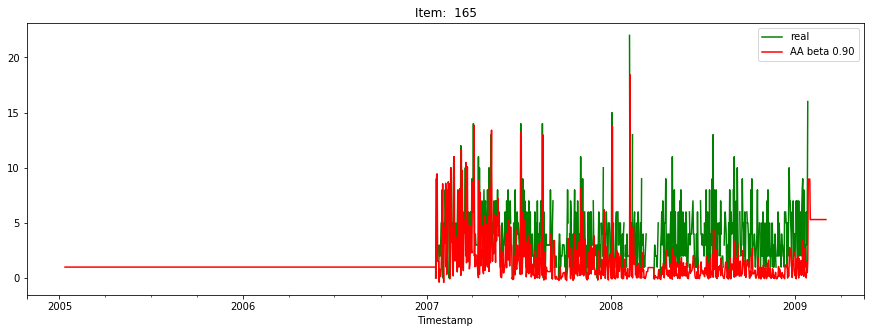

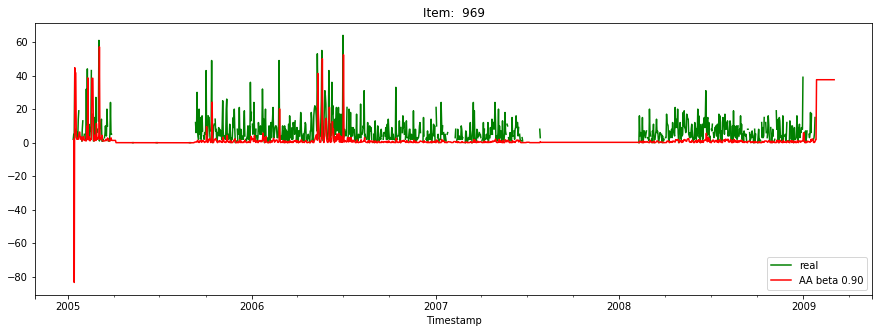

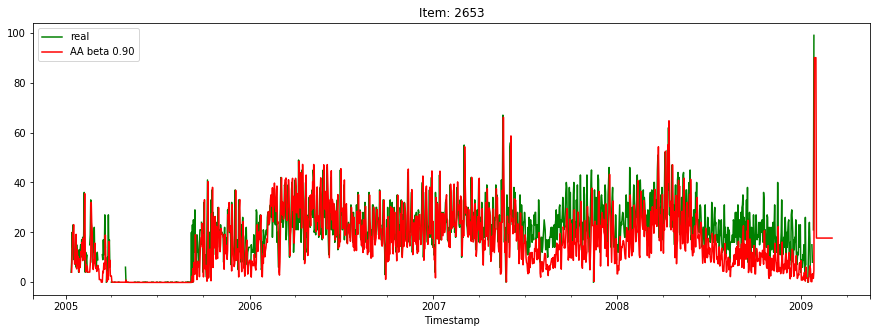

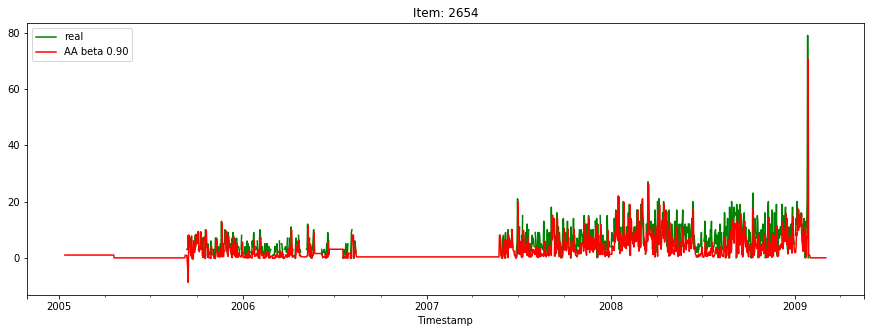

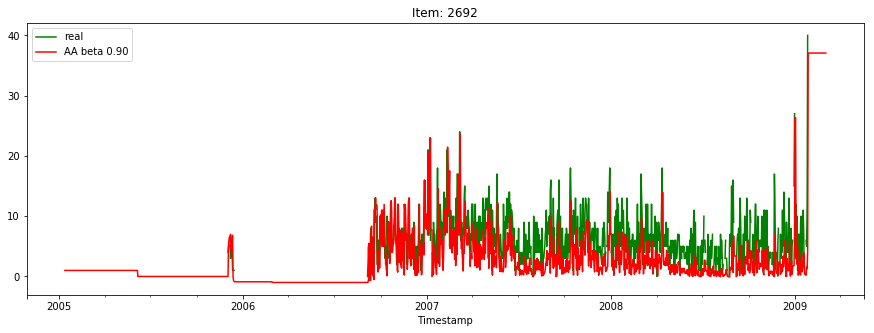

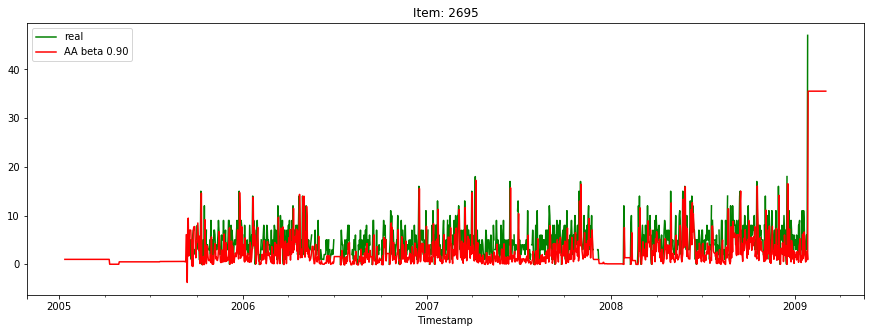

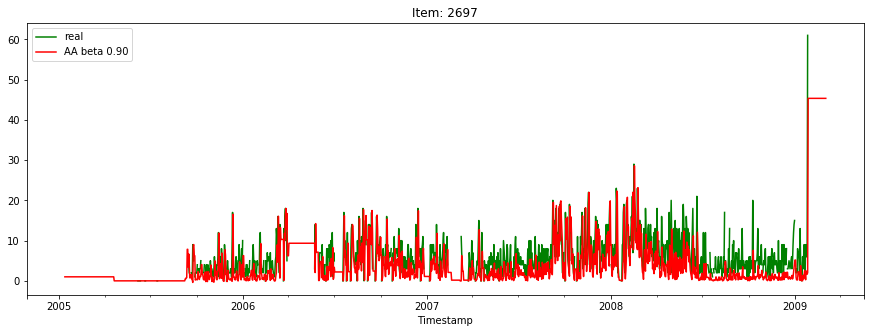

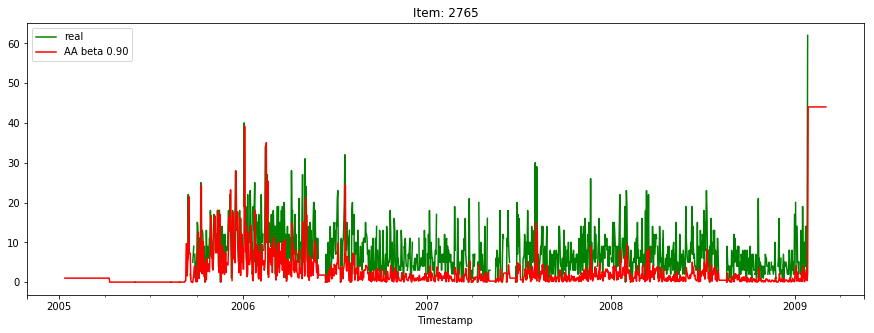

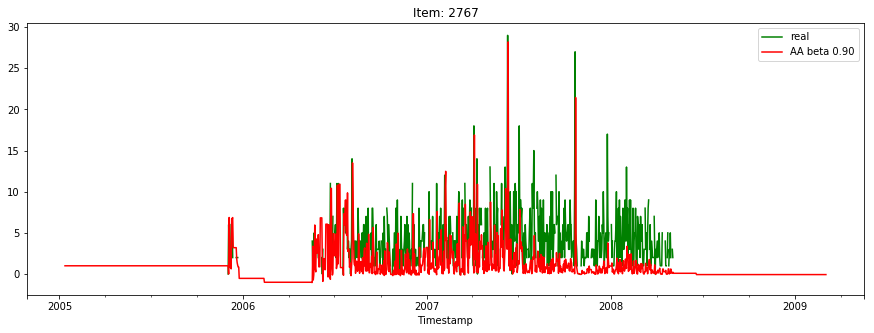

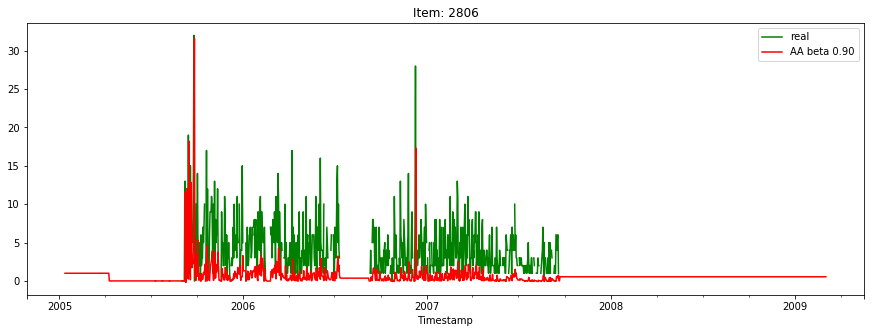

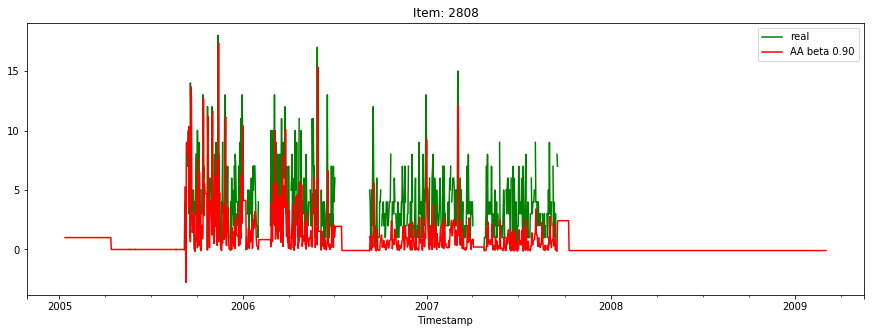

In [35]:
# draw forecast of Aggregating Algorithm
alg_name = 'AA beta 0.90'
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    forecast = FRC_TS[alg_name]
    forecast[col].plot(color='red', label=alg_name)
    plt.title(col)
    plt.legend()
    plt.show()